# Molecular Derivatives

> ### In this tutorial we will cover:
> - how we can automatically generate derivatives of molecules by targeted changes

BuildAMol presents first and foremost a framework that allows users to design molecules on their own initiative, by assembling molecular fragments and adjusting the generated structures. However, in many applications, such as drug design, we often do not have a clear idea about the exact molecule wer are interested in. Instead, we may only have a broad idea about the chemical class of molecule we are looking for but the precise nature of its structure. 

BuildAMol offers an extension named `molecular_factories` which contains pre-implemented classes to help with automated molecule creation. In this tutorial we will be using on factory named the `Derivator` to make "molecule derivatives" from a starting compound. 

The Derivator
-------------
The `Derivator` is a class that takes in a starting molecule and information on possible modifications to do. Possible modifications include:
- changing the element of an atom
- changing the order of a bond
- adding a functional group onto an atom (or any other function working on a specific atom)
- any function that modifies the molecule as a whole

Using these the `Derivator` offers methods `make`, `sample`, and `all` to generate derivative molecules that contain applied modifications.
- `make` allows the user to make a specific derivative based on the potential changes that were specified
- `sample` allows the user to create one or more random derivatives in a stochastic way
- `all` allows the user to generate all combinatorically possible molecule derivatives

So, with all that said, let's dive into an example!

## Example 1

As a first try, let's start with a benzene ring and modify the following:
- atom `C1` could be a `C`, `N`, or `O`
- atom `C3` could be a `C`, or `N`
- we could have a `carboxyl` or an `amide` group at atom `C4`

So, how do we set up this kind of simulation?

In [1]:
import buildamol as bam
from buildamol.extensions.molecular_factories import Derivator

# create the benzene starting molecule
bam.load_small_molecules()
benzene = bam.get_compound("benzene")

# create the derivator object
derivator = Derivator(benzene)

Now we can specify our desired modifications like so:

In [2]:
# we can give any atom identifier as "atom" argument, or the an atom object
derivator.element_changable(atom="C1", elements=("C", "N", "O"))
derivator.element_changable(atom="C3", elements=("C", "N"))

derivator.functional_group_addable(atom="C4", group_modifiers=(bam.carboxylate, bam.amidate))

And with that done we can try to sample a possible molecule like so:

In [3]:
# sample is a generator that will yield molecules
mol = next(derivator.sample())
mol.py3dmol().show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Cool! So we have a molecule with some changes applied. Since we actually don't have that many changes we can also use `all` to compute all possible molecules from the changes we specified. Here's how:

In [4]:
# make a list of all possible molecules
# all is a generator that will yield molecules
mols = list(derivator.all())
print(f"Number of possible molecules: {len(mols)}")

Number of possible molecules: 10


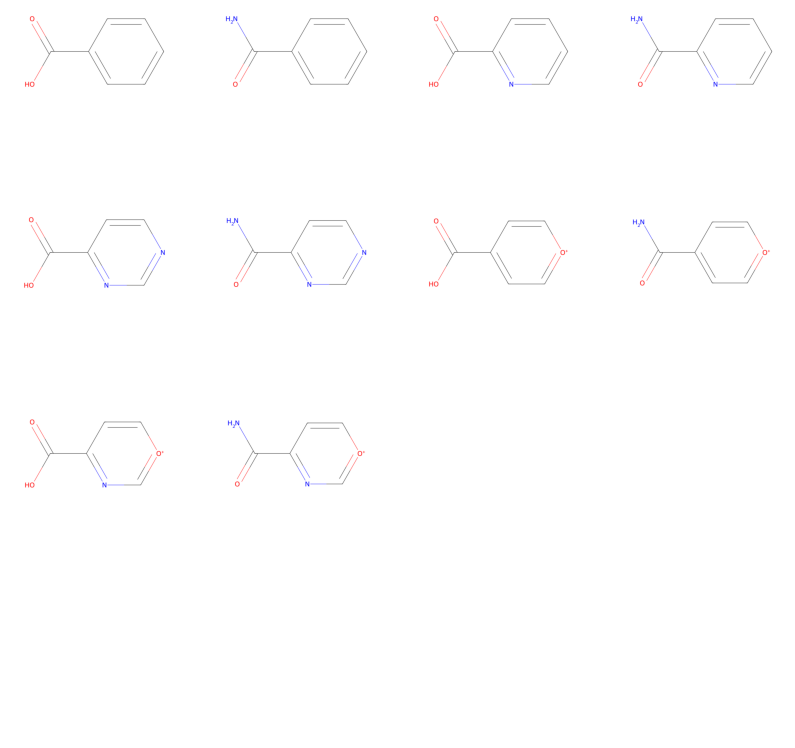

In [5]:
# let's visualize the molecules
import matplotlib.pyplot as plt
import numpy as np

# make a nice grid of subplots
rows = np.sqrt(len(mols))   
cols = np.ceil(len(mols) / rows)
rows = np.ceil(rows)
fig, axs = plt.subplots(int(rows), int(cols), figsize=(10, 10))

for i, mol in enumerate(mols):
    ax = axs[int(i // cols), int(i % cols)]
    ax.imshow(mol.chem2dview().draw())
for ax in axs.flat:    
    ax.axis("off")

And there we have all our possible molecules that fulfill our specifications! 

## Example 2

We can also take this a step further and make a more elaborate pipeline, where we have more options and therefore a larger molecule space. If we have a large number of possible combinations it can get exhaustive to compute all possibilities so we may want to rely on `sample` or `make` instead. We can specify _probabilities_ for specific modifications to guide how frequently they are chosen by the sampling algorithm and thereby make sure that "less likely" alterations are not given too much attention. 

To illustrate this, let's make a second example where we add a wider variety of possible modifications! Also, let's add a custom global modifier that will circularize our molecule targets with either 6-membered or 5-membered rings!

In [6]:
# let's start from a di-benzene ring
start = bam.read_smiles("C1(C=CC=C2)=C2C=CC=C1")
start.autolabel()
# so that we know which atom is where
start.plotly().show()

/Users/noahhk/anaconda3/envs/glyco2/lib/python3.11/site-packages/plotly/express/_core.py:1985: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [7]:

derivator = Derivator(start)

# let's add some modifiers
# (this time we specify the probability for each element)
derivator\
    .element_changable("C10", ("C", "N", "O"), probabilities=(0.5, 0.3, 0.2))\
    .element_changable("C8", ("C", "N"), probabilities=(0.6, 0.4))\
    .element_changable("C6", ("C", "N", "S"), probabilities=(0.5, 0.3, 0.2))

derivator\
    .functional_group_addable("C5", (bam.carboxylate, bam.amidate), probabilities=(0.5, 0.5))\
    .functional_group_addable("C7", (bam.hydroxylate, bam.aminate, bam.thiolate), probabilities=(0.5, 0.4, 0.1))\
    .functional_group_addable("C9", (bam.aminate, derivator.nothing), probabilities=(0.3, 0.7))

next(derivator.sample()).py3dmol().show()


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Now let's define a modifier function that will circularize the molecule at the carboxyl or amide group at atom C5, adding a third ring. However, we want that ring to have either six or five member atoms, so we will dynamically one or two more carbon atoms onto atom C4. Sounds a bit complex? Well, maybe but let's see what our function looks like:

In [8]:

# and now let's also define a custom global modifier that will circularize part of the molecule
# with either 5 or 6 atoms

def circularize_at_c5_branch(mol):
    
    # the functional group at C5 will be residue 2 (since it's the first functional group we add)
    # we will get the N or O neighbor of the carbonyl carbon and connect it to the aromatic ring by adding
    # either one or two carbons at the C4 position
    neighbor = mol.get_neighbors(
        mol.get_residue(2).get_atom("C"),
        filter = lambda x: x.element in ("N", "O") and x.id != "O"
    )
    neighbor = neighbor.pop()

    # add one or two carbons at C4
    # (with a 50% probability for either case)
    atom = mol.get_hydrogen("C4")
    mol.change_element(atom, "C").rename_atom(atom, "CA")
    if np.random.rand() < 0.5:
        atom = mol.get_hydrogen(atom)
        mol.change_element(atom, "C").rename_atom(atom, "CB")

    # add a bond from the neighbor to the new carbon
    mol.add_bond(neighbor, atom)
    Ha = mol.get_hydrogen(atom)
    if Ha is not None:
        mol.remove_atoms(Ha)
    Hn = mol.get_hydrogen(neighbor)
    if Hn is not None:
        mol.remove_atoms(Hn)
        
    # since we added a circle we need to optimize with rdkit
    mol.optimize(algorithm="mmff", inplace=True)

# now add the modifier
derivator.global_modifiers([circularize_at_c5_branch])

# and sample a molecule
next(derivator.sample()).py3dmol().show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Okey, let's try to sample some molecules using our set up derivator:

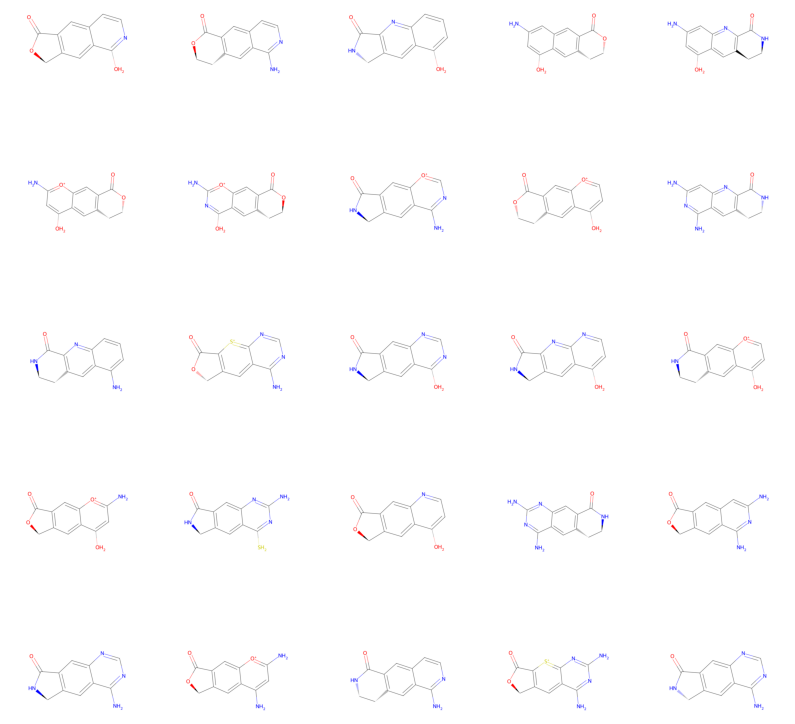

In [9]:
fig, axs = plt.subplots(5, 5, figsize=(10, 10))

# create 25 molecules
for i, mol in enumerate(derivator.sample(25)):
    ax = axs.flat[i]
    ax.imshow(mol.chem2dview().draw())
    ax.axis("off")

plt.show()

And there we have a bunch of sampled molecule derivatives!

## Example 3

So far we have seen `all` and `sample` in action. Then, what is the purpose of `make`? The `make` method accepts numeric inputs in form of arrays to specify what kinds of modifications to specifically apply when generating derivatives. It is designed to facilitate the use of the `Derivator` in machine learning or optimization pipelines, which work with numeric data. 

Let's make an example to understand how we use the `make` method. In summary, the method accepts four 1D arrays, each of the length of specified atoms/bonds/modifiers. Each entry in the arrays is the index of the respective element/bond order/modifier to apply. Of course, a user is free to design their own numeric encoding/decoding for the Derivator if they find another system more convenient for their pipeline! 

In [ ]:
# let's use again benzene
benzene = bam.get_compound("benzene")

derivator = Derivator(benzene)

# define potential modifications
# (we keep the order of specifications in mind, for later)
derivator.element_changable("C1", ("C", "N", "O"))
derivator.element_changable("C3", ("C", "N"))
derivator.functional_group_addable("C4", (bam.carboxylate, bam.amidate))

To now make a "benzene with C1 as Oxygen and C3 as Nitrogen, and a carboxyl group at C4" we would specify the following arrays:

In [12]:
# the first entry is for C1 (the first specified element_changable)
# the second entry is for C3 (the second specified element_changable)
# the 2 indicates the index of O in the tuple ("C", "N", "O")
# the 1 indicates the index of N in the tuple ("C", "N")
elements = [2, 1]

# the first entry is for C4 (the first and only specified functional_group_addable)
# the 0 indicates the index of carboxylate in the tuple (bam.carboxylate, bam.amidate)
functional_groups = [0]

# now we can make the derivative
# (we have to provide empty arrays for all other arguments)
derivator.make(elements=elements, bonds=[], groups=functional_groups, modifiers=[]).py3dmol().show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

And with that we have reached the end of this tutorial. We saw how we can generate molecular derivatives from a starting compound and a bunch of specified potential modifications using the `Derivator` class. Thanks for checking out this tutorial and good luck with your project using BuildAMol!